In [72]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker, declarative_base
from easynmt import EasyNMT
from transformers import BertModel, BertTokenizer
import torch
import umap
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer
import yake

DB Connection

In [2]:
engine = create_engine('sqlite:////Users/quimpm/uni/twitter_profiling/twitter_profiling.db')
Session = sessionmaker(bind=engine)
session = Session()
Base = declarative_base()

In [3]:
from sqlalchemy import Column, Integer, String


class Tweet(Base):
    __tablename__ = 'tweet'

    id = Column(Integer, primary_key=True)
    user_id = Column(Integer)
    exec_id = Column(String)
    username = Column(String)
    at = Column(String)
    text = Column(String)
    views = Column(Integer)
    replies = Column(Integer)
    retweets = Column(Integer)
    likes = Column(Integer)
    imgs = Column(String)
    video = Column(String)
    link = Column(String)
    time = Column(String)

    def __init__(self, exec_id, user_id, username, at, text, views, replies, retweets, likes, imgs, video, link, time):
        self.exec_id = exec_id
        self.user_id = user_id
        self.username = username
        self.at = at
        self.text = text.replace("\n", " ").replace(",", " ").replace("  ", " ")
        self.views = views
        self.replies = replies
        self.retweets = retweets
        self.likes = likes
        self.imgs = "|".join(imgs)
        self.video = video
        self.link = link
        self.time = time

    def __hash__(self):
        return hash(f'{self.exec_id}{self.username}{self.at}{self.text}{str(self.views)}{str(self.replies)}{str(self.retweets)}{str(self.likes)}{self.imgs}{self.video}{self.link}{self.time}')

In [4]:
class Document(Base):
    __tablename__ = 'document'

    id = Column(Integer, primary_key=True)
    exec_id = Column(String)
    corpus_id = Column(Integer)
    text = Column(String)

    def __init__(self, exec_id, corpus_id, text):
        self.exec_id = exec_id
        self.corpus_id = corpus_id
        self.text = text

In [5]:
def translate_text(text):
    model = EasyNMT('opus-mt')
    try:
        return model.translate(text, target_lang="en")
    except:
        return text

In [39]:
documents = session.query(Tweet).filter_by(exec_id="46abe110-933a-11ed-b21f-96c090691d1b").all()
documents_text = list(map(lambda x: translate_text(x.text), documents))
documents_text[:10]

Exception: Helsinki-NLP/opus-mt-ms-en is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo with `use_auth_token` or log in with `huggingface-cli login` and pass `use_auth_token=True`.
Exception: Helsinki-NLP/opus-mt-sl-en is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo with `use_auth_token` or log in with `huggingface-cli login` and pass `use_auth_token=True`.
/opt/homebrew/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/opt/homebrew/lib/python3.10/site-packages/transformers/generation/utils.py:1387: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `ma

['Ah sushi!',
 'Talking to a big group today. Professionalism Architecture Agile and Clean Code. It’s going to be a blast! I love being on stage. It’s a personality defect.',
 'The NOTAM corruption nearly caused me to scrub a client visit. But I managed by minutes to sneak onto a delayed flight going to an airport 120 miles from my destination and drive the rest of the way. Traded F/C for center seat.  The things we do for our clients! ;-)',
 '#datomic is a functional database that I’ve used before. I have a feeling that this application could plumb some of its depths. I’m looking forward to the experiments.',
 'I’m deeply into the final case study now. This one is going to be very interesting.',
 'The US national debt is ~$32 000 000 000 000. The US population is ~332 000 000. That’s ~$96 000 for every man woman and child in the country.  And this doesn’t count the much greater unfunded liabilities. And nobody cares.  But the Piper _will_ be paid.',
 'Finished Abstract Factory added a

In [40]:
df = pd.DataFrame(documents_text, columns =['text'])
df

,text
0,Ah sushi!
1,Talking to a big group today. Professionalism ...
2,The NOTAM corruption nearly caused me to scrub...
3,#datomic is a functional database that I’ve us...
4,I’m deeply into the final case study now. This...
...,...
95,Good morning!
96,Turn down the lights. Pour a nice glass of win...
97,From my point of view the more social networks...
98,The dream of a graphical programming language ...


Get BERT Embedings

In [41]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [42]:
def get_embeddinngs(text):
    inputs = tokenizer(text, return_tensors="pt")
    return model(**inputs).pooler_output.tolist()

def flat_map(f, xs):
    ys = []
    for x in xs:
        ys.extend(f(x))
    return ys

In [43]:
df['emb'] = df['text'].apply(get_embeddinngs)
df

,text,emb
0,Ah sushi!,"[[-0.8653967380523682, -0.31181463599205017, -..."
1,Talking to a big group today. Professionalism ...,"[[-0.8087637424468994, -0.28971341252326965, -..."
2,The NOTAM corruption nearly caused me to scrub...,"[[-0.6886597871780396, -0.37573152780532837, -..."
3,#datomic is a functional database that I’ve us...,"[[-0.842597484588623, -0.40513572096824646, -0..."
4,I’m deeply into the final case study now. This...,"[[-0.8636285662651062, -0.38201189041137695, -..."
...,...,...
95,Good morning!,"[[-0.82135009765625, -0.21561743319034576, 0.0..."
96,Turn down the lights. Pour a nice glass of win...,"[[-0.8620830178260803, -0.19205379486083984, -..."
97,From my point of view the more social networks...,"[[-0.8946113586425781, -0.5404593348503113, -0..."
98,The dream of a graphical programming language ...,"[[-0.856700599193573, -0.5784740447998047, -0...."


Reduce Dimensionality

In [44]:
embeddings = list(map(lambda x: x[0], df['emb']))

In [45]:
len(embeddings[0])

768

In [46]:
umap_embeddings = umap.UMAP(metric='cosine').fit_transform(embeddings)

Let's try to finetune epsilon parameter of DBSCAN

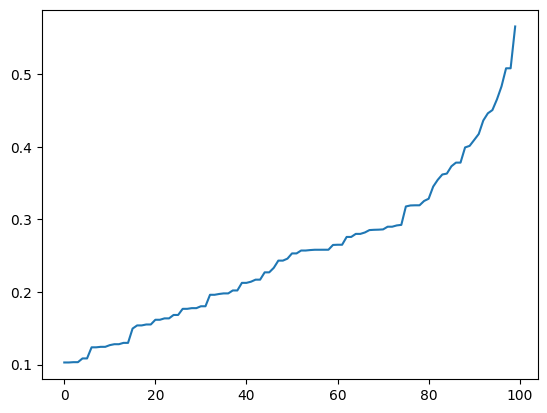

In [47]:
def plot_neighbour_distance(umap_embeddings):
    neigh = NearestNeighbors(n_neighbors=4)
    nbrs = neigh.fit(umap_embeddings)
    distances, indices = nbrs.kneighbors(umap_embeddings)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)

plot_neighbour_distance(umap_embeddings)

As we have 2dimensional data (Vectors) we will set the minimum cluster size fixed to 4 as it is mentioned in the Presentation paper of DBSCAN: 

"DBSCAN needs two parameters, Eps and MinPts. However, our experiments indicate that the k-dist graphs for k > 4
do not significantly differ from the 4-dist graph and, furthermore, they need considerably more computation. Therefore,
we eliminate the parameter MinPts by setting it to 4 for all
databases (for 2-dimensional data)."

The optimal value for epsilon will be found at the point of maximum curvature. This means arround 0.4

Let's create the clusters! We will use DB scan as we don't know the number of clusters found in the data

In [48]:
db = DBSCAN(eps=0.35, metric = 'euclidean', min_samples=4).fit(umap_embeddings)
labels = db.labels_

In [49]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [50]:
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 8
Estimated number of noise points: 60


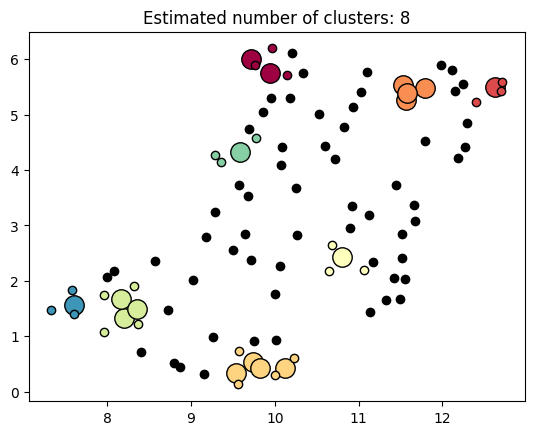

In [51]:
def plot_clusters(labels, n_clusters_, db):
    unique_labels = set(labels)
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = labels == k

        xy = umap_embeddings[class_member_mask & core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
        )

        xy = umap_embeddings[class_member_mask & ~core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )

    plt.title(f"Estimated number of clusters: {n_clusters_}")
    plt.show()
    
plot_clusters(labels, n_clusters_, db)

In [52]:
labels

array([-1, -1,  0,  6, -1, -1, -1, -1, -1,  4, -1, -1, -1,  0, -1, -1, -1,
       -1,  4, -1, -1,  4, -1, -1, -1, -1, -1,  1,  2, -1, -1, -1, -1, -1,
       -1,  3, -1, -1,  2,  5, -1,  7,  4, -1, -1,  3, -1, -1,  5, -1, -1,
       -1, -1, -1, -1,  0, -1,  3,  0, -1,  0,  6, -1,  1,  2,  2, -1,  3,
        3,  3,  5,  7,  5,  5,  3,  7, -1,  5, -1, -1, -1, -1,  5, -1, -1,
        1,  7, -1, -1, -1, -1, -1,  1, -1,  6, -1,  6, -1,  3, -1])

In [53]:
df['cluster'] = labels
df

,text,emb,cluster
0,Ah sushi!,"[[-0.8653967380523682, -0.31181463599205017, -...",-1
1,Talking to a big group today. Professionalism ...,"[[-0.8087637424468994, -0.28971341252326965, -...",-1
2,The NOTAM corruption nearly caused me to scrub...,"[[-0.6886597871780396, -0.37573152780532837, -...",0
3,#datomic is a functional database that I’ve us...,"[[-0.842597484588623, -0.40513572096824646, -0...",6
4,I’m deeply into the final case study now. This...,"[[-0.8636285662651062, -0.38201189041137695, -...",-1
...,...,...,...
95,Good morning!,"[[-0.82135009765625, -0.21561743319034576, 0.0...",-1
96,Turn down the lights. Pour a nice glass of win...,"[[-0.8620830178260803, -0.19205379486083984, -...",6
97,From my point of view the more social networks...,"[[-0.8946113586425781, -0.5404593348503113, -0...",-1
98,The dream of a graphical programming language ...,"[[-0.856700599193573, -0.5784740447998047, -0....",3


In [71]:
list(df[df['cluster'] == 2]['text'])

['Do I use UML? Sure sometimes.  Do carpenters use hammers? Carpenters nowadays have nail guns; but sometimes only a hammer will do.',
 'CH4 is a very efficient GHG. It traps 30X more heat than CO2. During the pandemic atmospheric CH4 increased significantly because we decreased the usage of fossil fuels which release the hydroxyls that degrade CH4.  TANSTAAFL',
 'One of the more common mistakes that programmers make when implementing cellular automata is to actually create a grid of cells in computer memory.',
 'That ability to communicate intent is the whole reason that design patterns are useful. The patterns themselves are not new nor even very interesting; but the ability to name them is a huge advantage.',
 'Do some languages have features that obviate certain design patterns? Not in my experience. Rather there are some language features that facilitate certain patterns.  As a simple example consider the Strategy pattern.  ']

## Let's try with a more specific Bert Model: BerTweet

In [55]:
bertweet = AutoModel.from_pretrained("vinai/bertweet-base")
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [56]:
tensors = [torch.tensor([tokenizer.encode(tweet)]) for tweet in documents_text]
features = []
with torch.no_grad():
    for tensor in tensors:
        features.append(bertweet(tensor).pooler_output.tolist())
features = list(map(lambda x: x[0], features))

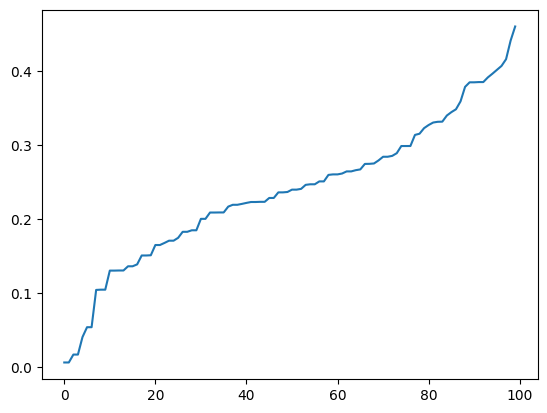

In [57]:
umap_embeddings = umap.UMAP(metric='cosine').fit_transform(features)
plot_neighbour_distance(umap_embeddings)

In [58]:
db = DBSCAN(eps=0.35, metric = 'euclidean', min_samples=4).fit(umap_embeddings)
labels = db.labels_

In [59]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 6
Estimated number of noise points: 45


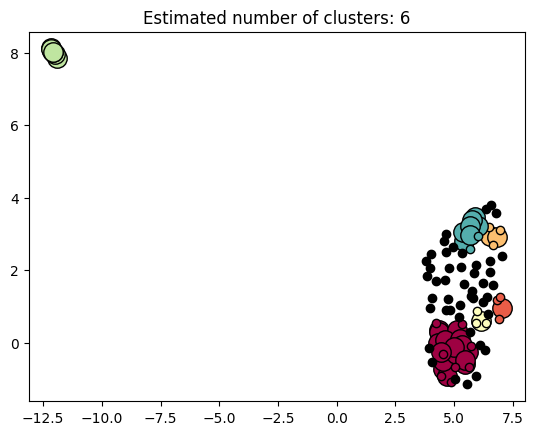

In [60]:
plot_clusters(labels, n_clusters_, db)

In [61]:
df2 = df
df2['cluster'] = labels
df2

,text,emb,cluster
0,Ah sushi!,"[[-0.8653967380523682, -0.31181463599205017, -...",-1
1,Talking to a big group today. Professionalism ...,"[[-0.8087637424468994, -0.28971341252326965, -...",1
2,The NOTAM corruption nearly caused me to scrub...,"[[-0.6886597871780396, -0.37573152780532837, -...",0
3,#datomic is a functional database that I’ve us...,"[[-0.842597484588623, -0.40513572096824646, -0...",1
4,I’m deeply into the final case study now. This...,"[[-0.8636285662651062, -0.38201189041137695, -...",-1
...,...,...,...
95,Good morning!,"[[-0.82135009765625, -0.21561743319034576, 0.0...",0
96,Turn down the lights. Pour a nice glass of win...,"[[-0.8620830178260803, -0.19205379486083984, -...",-1
97,From my point of view the more social networks...,"[[-0.8946113586425781, -0.5404593348503113, -0...",3
98,The dream of a graphical programming language ...,"[[-0.856700599193573, -0.5784740447998047, -0....",5


In [68]:
list(df2[df2['cluster'] == 5]['text'])

['New requirement. Anyone writing definitions for a dictionary must complete the #AdventOfCode every year to prove that they still have a functioning brain.',
 'Day 12 of #AdventOfCode2022 pretends to be a simple depth first search. I got the test data working; but then had to go to the airport. My ninth grandchild is on the way.  The trick to solving the real problem is likely in finding the right pruning strategies.',
 'Some arguments against the position that software has reached a pinnacle.  - Experts predicting pinnacles are often wrong.  - Hardware revolutions like Quantum Neural Hybrid Analog.  - ML might have non-linear growth.  - SkyNet.',
 'An argument for the position that software has reached a pinnacle:  Software has been constructed from sequence selection and iteration since it’s inception in 1936.  There have been no major structural paradigms uncovered since 1966.',
 'Regardless of the language being used developers can discuss whether or not the Strategy pattern would

## Goood, I think ot works way better!!

We would like to have real labels instead of numbers for each of the topics that have been classified. For doing so, I though on diferent possible euristics: 

- TF-IDF: to get out the most relevant words for each of the topics.
- Keyword Extraction: Keyword extraction tool such as Yake!


Let's try Yake.

In [85]:
list(df2[df2['cluster'] == 1]['text'])

['Talking to a big group today. Professionalism Architecture Agile and Clean Code. It’s going to be a blast! I love being on stage. It’s a personality defect.',
 '#datomic is a functional database that I’ve used before. I have a feeling that this application could plumb some of its depths. I’m looking forward to the experiments.',
 'I’ve been using Clojure now for over 15 years. I’ve used it for projects big and small. It is a beautiful language. You should try it. ;-)',
 'Somebody hooked up ChatGPT to nostr. It’s an absolute hoot. It’s like talking to a lefty brainwashed college student pasting google responses into their phone. Naive. Shallow. But not entirely dumb.']

In [94]:
topics = []
kw = []
for i in range(n_clusters_):
    topics.append(" ".join(list(df2[df2['cluster'] == i]['text'])))
topics
kw_extractor = yake.KeywordExtractor(n=2, top=5)
for topic in topics:
    kw.append(list(map(lambda x: x[0], sorted(kw_extractor.extract_keywords(topic), reverse=True, key=lambda y: y[1]))))
kw

[['Abstract Factory', 'Twitter', 'NOTAM', 'client visit', 'NOTAM corruption'],
 ['big group',
  'Professionalism Architecture',
  'Architecture Agile',
  'Clean Code',
  'group today'],
 ['design patterns', 'efficient GHG', 'carpenters', 'patterns', 'UML'],
 ['power', 'control', 'profile', 'control speech', 'speech'],
 ['Easy peasy', 'Advent', 'Code', 'Day', 'Distress Signal'],
 ['functional programming',
  'Hybrid Analog',
  'requirement',
  'software',
  'programming']]

## BEAUTIFULL!